In [16]:
!pip install graphviz



In [17]:
import math
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import torch

In [18]:
def f(x):
    return 3*x**2 - 4*x + 5

In [19]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

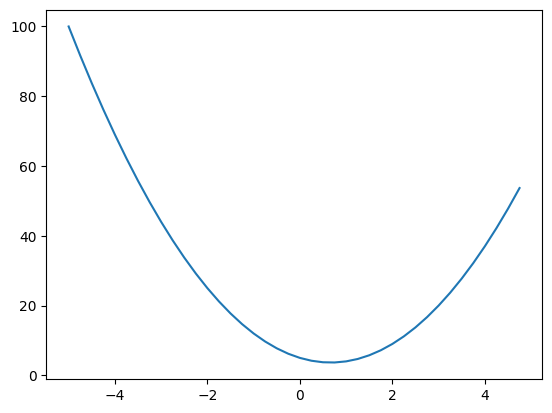

In [20]:
plt.plot(xs, ys)

In [21]:
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h


2.999378523327323e-06

In [22]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)


4.0


In [23]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [59]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set( _children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')       
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'currently only supports int and float powers'
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out 

    def __rmul__(self, other):
        return self * other
        
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [25]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [26]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) +n2._op)
        
    return dot

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
# inputs x1, x2:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights ws1, w2:
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron:
b = Value(6.88137355870195432 , label='b')
# x1w1 + x2w2 + b:
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'output'
o.backward()

In [ ]:
draw_dot(o)


In [58]:
# inputs x1, x2:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights ws1, w2:
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron:
b = Value(6.88137355870195432 , label='b')
# x1w1 + x2w2 + b:
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# --------- 
e = (2*n).exp()
o = (e-1)/(e+1)
# ----------
o.label = 'output'
o.backward()
draw_dot(o)

NameError: name 'draw_dot' is not defined

In [ ]:

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward

In [ ]:
draw_dot(o)

In [ ]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [ ]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d= a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

In [380]:
import torch


x1 = torch.Tensor([2.0]).double() ; x1.requires_grad=True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad=True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('gradients:')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('\n\n')






0.7071066904050358
-----
gradients:
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737





In [402]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [403]:
o.item()

0.7071066904050358

In [404]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
        
    def parameters(self):
        return self.w + [self.b]
        # returns parameters list, named the same as pytorch version
        
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# above list replaces:
    # def parameters(self):
    #     params = []
    #     for neuron in self.neurons:
    #         ps = neuron.parameters()
    #         params.extend(ps)
    #     return params


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [405]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4, 4, 1])
n(x), n(x).data


(Value(data=-0.06062870268643003), -0.06062870268643003)

In [406]:
n.parameters()

[Value(data=0.5704124932629417),
 Value(data=0.9344072077616954),
 Value(data=-0.44181817380117216),
 Value(data=0.3829428494872893),
 Value(data=-0.5400704656030397),
 Value(data=0.8873615138339106),
 Value(data=-0.2823768858625315),
 Value(data=-0.6997027715166455),
 Value(data=-0.41961833654403646),
 Value(data=0.7669445195799538),
 Value(data=0.3226261490453417),
 Value(data=-0.701757085626955),
 Value(data=0.36915441390506687),
 Value(data=0.3751236733553218),
 Value(data=-0.16533369855296343),
 Value(data=0.6781857392116484),
 Value(data=-0.39421626275448896),
 Value(data=-0.4346791054694892),
 Value(data=0.29948475129913965),
 Value(data=-0.4716455117829881),
 Value(data=0.5180440208983841),
 Value(data=-0.8675174297582804),
 Value(data=0.3737622215097649),
 Value(data=0.8699258997033323),
 Value(data=0.3085864666149689),
 Value(data=-0.25285631393508257),
 Value(data=0.0707139543876818),
 Value(data=-0.736455652569123),
 Value(data=0.44016676099164176),
 Value(data=-0.207038515

In [407]:
xs= [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]


In [408]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.1437421686468046)

In [409]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [410]:
# y prediction loss:  y ground truth and y output 
# predicted output minus ground truth, squared
#  final loss is sum of losses, ie sum of all (pred-truth)**2 

ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=3.1437421686468046)

In [411]:
loss.backward()

In [412]:
# the effect of this node on the loss

n.layers[0].neurons[0].w[0].grad

-0.047497500869098416

In [413]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [414]:
ypred

[Value(data=-0.06062870268643003),
 Value(data=-0.5658484603255163),
 Value(data=-0.4510963568421847),
 Value(data=-0.23653797143915367)]

In [441]:
n.parameters()


[Value(data=-2.0402773005259123),
 Value(data=0.4623604404599153),
 Value(data=-1.046267837935674),
 Value(data=-1.320818084126585),
 Value(data=0.5025875398253395),
 Value(data=-1.469765276496885),
 Value(data=-15.092132907054136),
 Value(data=-4.929227288546092),
 Value(data=-5.355068790437663),
 Value(data=-6.148355942180005),
 Value(data=3.8620951341961227),
 Value(data=-3.2295439414970026),
 Value(data=-3.1827163060166),
 Value(data=0.3985255686348525),
 Value(data=-4.2609755034365735),
 Value(data=-2.178727819961419),
 Value(data=-4.918360118577227),
 Value(data=-9.035758175287713),
 Value(data=5.067506012883799),
 Value(data=-2.9271728327667805),
 Value(data=-3.394492925640982),
 Value(data=-1.1803043806667488),
 Value(data=-0.4184434593524537),
 Value(data=0.3515526026950951),
 Value(data=-0.06041435372690248),
 Value(data=-0.4122301760457361),
 Value(data=-2.1384320631417633),
 Value(data=-9.493229585127047),
 Value(data=-3.895716283651918),
 Value(data=-2.036870069407313),
 V

In [442]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [443]:
n.parameters()

[Value(data=-2.0402773005259123),
 Value(data=0.4623604404599153),
 Value(data=-1.046267837935674),
 Value(data=-1.320818084126585),
 Value(data=0.5025875398253395),
 Value(data=-1.469765276496885),
 Value(data=-15.092132907054136),
 Value(data=-4.929227288546092),
 Value(data=-5.355068790437663),
 Value(data=-6.148355942180005),
 Value(data=3.8620951341961227),
 Value(data=-3.2295439414970026),
 Value(data=-3.1827163060166),
 Value(data=0.3985255686348525),
 Value(data=-4.2609755034365735),
 Value(data=-2.178727819961419),
 Value(data=-4.918360118577227),
 Value(data=-9.035758175287713),
 Value(data=5.067506012883799),
 Value(data=-2.9271728327667805),
 Value(data=-3.394492925640982),
 Value(data=-1.1803043806667488),
 Value(data=-0.4184434593524537),
 Value(data=0.3515526026950951),
 Value(data=-0.06041435372690248),
 Value(data=-0.4122301760457361),
 Value(data=-2.1384320631417633),
 Value(data=-9.493229585127047),
 Value(data=-3.895716283651918),
 Value(data=-2.036870069407313),
 V

In [444]:
loss.data

    

8.027341335749713e-26

In [445]:
for k in range(20):

    # forward
    ypred =[n(x) for x in xs]
    loss = sum((yout -ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.08 * p.grad
    
    print(k, loss.data)


0 8.027341335749713e-26
1 8.027341335749713e-26
2 8.027341335749713e-26
3 8.027341335749713e-26
4 8.027341335749713e-26
5 8.027341335749713e-26
6 8.027341335749713e-26
7 8.027341335749713e-26
8 8.027341335749713e-26
9 8.027341335749713e-26
10 8.027341335749713e-26
11 8.027341335749713e-26
12 8.027341335749713e-26
13 8.027341335749713e-26
14 8.027341335749713e-26
15 8.027341335749713e-26
16 8.027341335749713e-26
17 8.027341335749713e-26
18 8.027341335749713e-26
19 8.027341335749713e-26


In [446]:
for k in range(20):

    # forward pass
    ypred =[n(x) for x in xs]
    loss = sum((yout -ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.08 * p.grad
    
    print(k, loss.data)


0 8.027341335749713e-26
1 8.027341335749713e-26
2 8.027341335749713e-26
3 8.027341335749713e-26
4 8.027341335749713e-26
5 8.027341335749713e-26
6 8.027341335749713e-26
7 8.027341335749713e-26
8 8.027341335749713e-26
9 8.027341335749713e-26
10 8.027341335749713e-26
11 8.027341335749713e-26
12 8.027341335749713e-26
13 8.027341335749713e-26
14 8.027341335749713e-26
15 8.027341335749713e-26
16 8.027341335749713e-26
17 8.027341335749713e-26
18 8.027341335749713e-26
19 8.027341335749713e-26
